# Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
from scipy.stats import ttest_rel, ttest_1samp, iqr
import pickle

import warnings
warnings.filterwarnings("ignore", category = UserWarning)

# Preprocessing

In [10]:
# Preprocess dataset (Outputs: ids, trial_nums, predictors_df, outcomes_df, outcomes_df_shuffled)
# Import dataset
df = pd.read_csv("./../Datasets/kieranFeatures_1-31_21-Jan-2025_avgof3_rawSA.csv").replace([np.inf, -np.inf], np.nan)

# Create Low vs High Columns
df["Lv_1_Lo"] = (df["SA1"] < 5).astype(np.bool_)
df["Lv_2_Lo"] = (df["SA2"] < 5).astype(np.bool_)
df["Lv_3_Lo"] = (df["SA3"] < 5).astype(np.bool_)
df["Tot_Lo"] = (df["SAtotal"] < 15).astype(np.bool_)

# Impute missing values with mean of column
for col in df.columns:
    df[col] = df[col].fillna(value = df[col].mean())

# Split up dataset
ids = df["ID"].astype(np.uint8)
predictors_df = df.drop(columns = ["ID", "trialNum", "SA1", "SA2", "SA3", "SAtotal", "Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]).astype(np.float64)
outcomes_df = df[["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo", "SA1", "SA2", "SA3", "SAtotal"]]
outcomes_df_shuffled = outcomes_df.copy()

# Shuffle labels for shuffled data
outcomes_df_shuffled["Lv_1_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_1_Lo"])
outcomes_df_shuffled["Lv_2_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_2_Lo"])
outcomes_df_shuffled["Lv_3_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_3_Lo"])
outcomes_df_shuffled["Tot_Lo"] = np.random.permutation(outcomes_df_shuffled["Tot_Lo"])

# Divide up dataframe
ids = df["ID"]
ECG_df = df.loc[:, [col for col in df if col.startswith("ECG")]]
EDA_df = df.loc[:, [col for col in df if col.startswith("EDA")]]
EEG_df = df.loc[:, [col for col in df if col.startswith("EEG")]]
EYE_df = df.loc[:, [col for col in df if col.startswith("EYE")]]
fNIRS_df = df.loc[:, [col for col in df if col.startswith("fNIRS")]]
RSP_df = df.loc[:, [col for col in df if col.startswith("RSP")]]
sensor_dfs = [(ECG_df, "ECG"), (EDA_df, "EDA"), (EEG_df, "EEG"), (EYE_df, "EYE"), (fNIRS_df, "fNIRS"), (RSP_df, "RSP")]

# Free up memory
del col, df, predictors_df

# Class Distributions

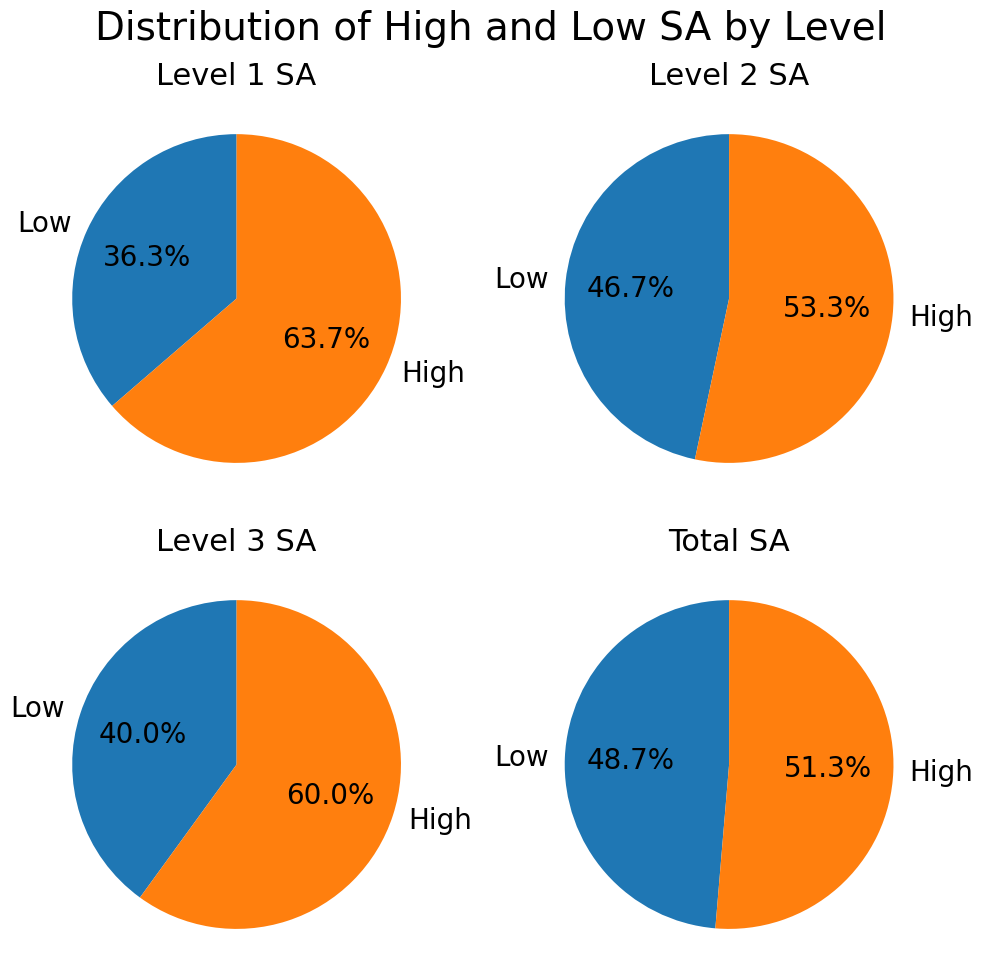

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize = (10, 10))
labels = ["Low", "High"]
colors = ["C0", "C1"]

ax1[0].set_title("Level 1 SA", fontsize = 22)
ax1[0].pie([np.sum(outcomes_df["Lv_1_Lo"]), np.sum(~outcomes_df["Lv_1_Lo"])], labels = labels, colors = colors, autopct = "%1.1f%%", startangle = 90, textprops = {"fontsize": 20})

ax1[1].set_title("Level 2 SA", fontsize = 22)
ax1[1].pie([np.sum(outcomes_df["Lv_2_Lo"]), np.sum(~outcomes_df["Lv_2_Lo"])], labels = labels, colors = colors, autopct = "%1.1f%%", startangle = 90, textprops = {"fontsize": 20})

ax2[0].set_title("Level 3 SA", fontsize = 22)
ax2[0].pie([np.sum(outcomes_df["Lv_3_Lo"]), np.sum(~outcomes_df["Lv_3_Lo"])], labels = labels, colors = colors, autopct = "%1.1f%%", startangle = 90, textprops = {"fontsize": 20})

ax2[1].set_title("Total SA", fontsize = 22)
ax2[1].pie([np.sum(outcomes_df["Tot_Lo"]), np.sum(~outcomes_df["Tot_Lo"])], labels = labels, colors = colors, autopct = "%1.1f%%", startangle = 90, textprops = {"fontsize": 20})

fig.suptitle("Distribution of High and Low SA by Level", fontsize = 28)
fig.tight_layout()
plt.savefig("./../Images/Paper Figures/Average_Of_3_SA_Distributions.svg")

# F1 and Accuracy Scores

In [11]:
# Load data
with open("./../Pickle Files/Weighted_Average_Scores.pkl", "rb") as f:
    f1_scores, accuracy_scores = pickle.load(f)

del f

In [12]:
def graph_actual_vs_shuffled(scores, metric):
    # Initialize scores data for plotting
    actual_scores = [scores["Actual"][level] for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]]
    shuffled_scores = [scores["Shuffled"][level] for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]]

    # Positions for main categories on x-axis
    x_base_positions = np.arange(1, len(actual_scores) + 1) # [1, 2, 3, 4]

    # Width of each individual boxplot
    box_width = 0.4

    # Calculate positions for actual and shuffled boxplots
    # Actual boxplots on left and shuffled on right
    positions_actual = x_base_positions - box_width / 2
    positions_shuffled = x_base_positions + box_width / 2

    # Define colors
    color_actual = "lightblue"
    color_shuffled = "lightcoral"

    # Plot Actual vs Shuffled
    fig = plt.figure(figsize = (3.5, 3))
    plt.boxplot(actual_scores,
                vert = True,
                positions = positions_actual,
                widths = box_width,
                label = "Actual",
                patch_artist = True,
                boxprops = dict(facecolor = color_actual, color = "black"),
                whiskerprops = dict(color = "black"),
                capprops = dict(color = "black"),
                medianprops = dict(color = "black"))
    plt.boxplot(shuffled_scores,
                vert = True,
                positions = positions_shuffled,
                widths = box_width,
                label = "Shuffled",
                patch_artist = True,
                boxprops = dict(facecolor = color_shuffled, color = "black"),
                whiskerprops = dict(color = "black"),
                capprops = dict(color = "black"),
                medianprops = dict(color = "black"))
    # Datapoints
    for i, (actual_score, shuffled_score) in enumerate(zip(actual_scores, shuffled_scores)):
        jitter = np.random.normal(-0.03, 0.03, size = len(actual_score))
        plt.plot([positions_actual[i] + jitter, positions_shuffled[i] + jitter], [actual_score, shuffled_score], linewidth = 0.75, color = "gray", alpha = 0.5)

    # Plot baselines
    score_baselines, always_true_baselines, always_false_baselines = get_baselines(metric)
    xmin_baselines = positions_actual - box_width / 2
    xmax_baselines = positions_shuffled + box_width / 2
    plt.hlines(score_baselines, xmin_baselines, xmax_baselines, color = "darkgreen", linestyle = "--", label = f"{metric}")
    if metric == "F1":
        plt.hlines(always_true_baselines, xmin_baselines, xmax_baselines, color = "r", linestyle = "--", label = "Always True")
    else:
        plt.hlines(always_false_baselines, xmin_baselines, xmax_baselines, color = "b", linestyle = "--", label = "Always False")

    # Labels
    level_labels = ["Level 1", "Level 2", "Level 3", "Total"]

    # Customize axes
    plt.ylabel(f"{metric} Score", fontsize = 9)
    plt.ylim(0, 1)
    plt.yticks(fontsize = 8)
    plt.xlabel("SA Level", fontsize = 9)
    plt.xticks(x_base_positions, level_labels, fontsize = 8)

    plt.legend(
        loc = "upper right",
        # bbox_to_anchor = (1.013, 1.015), # F1
        bbox_to_anchor = (1.0145, 1.015), # Accuracy
        fontsize = 7,
        ncol = 4,
        # columnspacing = 0.5) # F1
        columnspacing = 0.1)
    plt.tight_layout()
    plt.savefig(f"./../Images/Paper Figures/Actual_vs_Shuffled_{metric}_Scores.svg", bbox_inches = "tight")

def get_baselines(metric):
    # Initialize empty lists to store baseline values
    score_baselines = []
    always_true_baselines = []
    always_false_baselines = []

    for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
        # Initialize empty lists to store baseline values for `level`
        score_baseline_values = []
        always_true_baseline_values = []
        always_false_baseline_values = []

        # Get baselines for each fold
        skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
        for _, (_, test_idx) in enumerate(skf.split(outcomes_df, ids)):
            # Train-Test Split for the Fold
            out_test = outcomes_df.iloc[test_idx]

            if metric == "F1":
                score_baseline_values.append((np.mean(out_test[level])) / (np.mean(out_test[level]) + 0.5))
                always_true_baseline_values.append(f1_score(out_test[level], np.array([1 for _ in range(len(out_test[level]))])))
            elif metric == "ACC":
                score_baseline_values.append(0.5)
                always_false_baseline_values.append(accuracy_score(outcomes_df[level], np.array([0 for _ in range(len(outcomes_df[level]))])))
        
        # Append the baseline values for the current level
        score_baselines.append(np.mean(score_baseline_values))
        if metric == "F1":
            always_true_baselines.append(np.mean(always_true_baseline_values))
        else:
            always_false_baselines.append(np.mean(always_false_baseline_values))        

    return score_baselines, always_true_baselines, always_false_baselines

## F1 Scores

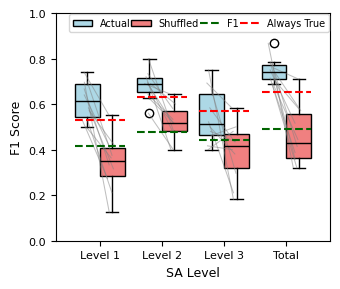

In [13]:
graph_actual_vs_shuffled(f1_scores, "F1")

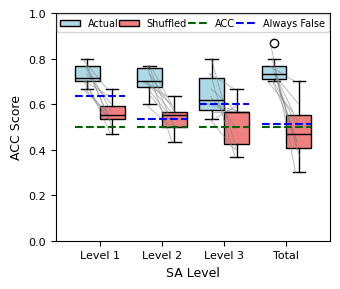

In [14]:
graph_actual_vs_shuffled(accuracy_scores, "ACC")

## Mean, Median, IQR Of F1 and Accuracy Across All Iterations

In [20]:
for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
    print(level)
    print(f"F1: {np.mean(f1_scores['Actual'][level]):.2f}")
    print(f"Accuracy: {np.mean(accuracy_scores['Actual'][level]):.2f}")
    print()

Lv_1_Lo
F1: 0.62
Accuracy: 0.73

Lv_2_Lo
F1: 0.68
Accuracy: 0.70

Lv_3_Lo
F1: 0.55
Accuracy: 0.64

Tot_Lo
F1: 0.75
Accuracy: 0.75



In [21]:
for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
    print(level)
    print(f"F1: {np.median(f1_scores['Actual'][level]):.2f}")
    print(f"Accuracy: {np.median(accuracy_scores['Actual'][level]):.2f}")
    print()

Lv_1_Lo
F1: 0.61
Accuracy: 0.72

Lv_2_Lo
F1: 0.69
Accuracy: 0.70

Lv_3_Lo
F1: 0.51
Accuracy: 0.62

Tot_Lo
F1: 0.74
Accuracy: 0.73



In [22]:
for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
    print(level)
    print(f"F1: {iqr(f1_scores['Actual'][level]):.2f}")
    print(f"Accuracy: {iqr(accuracy_scores['Actual'][level]):.2f}")
    print()

Lv_1_Lo
F1: 0.15
Accuracy: 0.07

Lv_2_Lo
F1: 0.06
Accuracy: 0.08

Lv_3_Lo
F1: 0.18
Accuracy: 0.14

Tot_Lo
F1: 0.06
Accuracy: 0.06



## T-Tests

In [4]:
def actual_vs_shuffled_t_test(model_scores, lvl):
    print(f'{"t" : <7}{"p" : <7}')
    t_stat, p_val = ttest_rel(
        model_scores["Actual"][lvl],
        model_scores["Shuffled"][lvl]
    )
    print(f'{t_stat : <7.3f}{p_val : >5.4f}')
    print()

def one_sample_t_test(model_scores, baseline_score, lvl):
    print(f'{"t" : <7}{"p" : <7}')
    t_stat, p_val = ttest_1samp(
        a = model_scores["Actual"][lvl], 
        popmean = np.mean(baseline_score))
    print(f'{t_stat : <7.3f}{p_val : >5.4f}')
    print()

def get_baselines(outcomes_df, lvl, ids):
    baseline_f1_scores = []
    baseline_f1_always_true_scores = []
    baseline_accuracy_score = 0.5
    baseline_accuracy_always_false_scores = []

    # Gather Baselines for Each Fold
    skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
    for i, (_, test_idx) in enumerate(skf.split(outcomes_df, ids)):
        out_test = outcomes_df.loc[test_idx, lvl].values

        # Calculate F1 Baseline
        precision = np.mean(out_test)
        recall = 0.5
        baseline_f1_scores.append(np.mean((2 * precision * recall) / (precision + recall)))

        # Calculate F1 Always True Baseline
        baseline_f1_always_true_scores.append(f1_score(out_test, np.array([1 for _ in range(len(out_test))])))

        # Calculate Accuracy Always False Baseline
        baseline_accuracy_always_false_scores.append(accuracy_score(out_test, np.array([0 for _ in range(len(out_test))])))

    return (np.mean(baseline_f1_scores), np.mean(baseline_f1_always_true_scores), baseline_accuracy_score, np.mean(baseline_accuracy_always_false_scores))

### F1

In [7]:
for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
    print(f"Actual vs Shuffled T-Test for {level}")
    actual_vs_shuffled_t_test(f1_scores, level)
    print()

    # Get Baselines for F1
    f1_baseline, f1_always_true_baseline, _, _ = get_baselines(outcomes_df, level, ids)

    print("vs F1 Baseline")
    one_sample_t_test(f1_scores, f1_baseline, level)
    print()

    print("vs F1 Always True Baseline")
    one_sample_t_test(f1_scores, f1_always_true_baseline, level)
    print()

Actual vs Shuffled T-Test for Lv_1_Lo
t      p      
7.006  0.0001


vs F1 Baseline
t      p      
7.509  0.0000


vs F1 Always True Baseline
t      p      
3.283  0.0095


Actual vs Shuffled T-Test for Lv_2_Lo
t      p      
5.820  0.0003


vs F1 Baseline
t      p      
10.074 0.0000


vs F1 Always True Baseline
t      p      
2.628  0.0274


Actual vs Shuffled T-Test for Lv_3_Lo
t      p      
2.452  0.0366


vs F1 Baseline
t      p      
2.724  0.0235


vs F1 Always True Baseline
t      p      
-0.600 0.5632


Actual vs Shuffled T-Test for Tot_Lo
t      p      
6.017  0.0002


vs F1 Baseline
t      p      
15.005 0.0000


vs F1 Always True Baseline
t      p      
5.499  0.0004




### Accuracy

In [8]:
for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
    print(f"Actual vs Shuffled T-Test for {level}")
    actual_vs_shuffled_t_test(f1_scores, level)
    print()

    # Get Baselines for Accuracy
    _, _, accuracy_baseline, accuracy_always_false_baseline = get_baselines(outcomes_df, level, ids)

    print("vs Accuracy Baseline")
    one_sample_t_test(accuracy_scores, accuracy_baseline, level)
    print()

    print("vs Accuracy Always False Baseline")
    one_sample_t_test(accuracy_scores, accuracy_always_false_baseline, level)
    print()

Actual vs Shuffled T-Test for Lv_1_Lo
t      p      
7.006  0.0001


vs Accuracy Baseline
t      p      
15.377 0.0000


vs Accuracy Always False Baseline
t      p      
6.106  0.0002


Actual vs Shuffled T-Test for Lv_2_Lo
t      p      
5.820  0.0003


vs Accuracy Baseline
t      p      
11.158 0.0000


vs Accuracy Always False Baseline
t      p      
9.329  0.0000


Actual vs Shuffled T-Test for Lv_3_Lo
t      p      
2.452  0.0366


vs Accuracy Baseline
t      p      
4.846  0.0009


vs Accuracy Always False Baseline
t      p      
1.385  0.1995


Actual vs Shuffled T-Test for Tot_Lo
t      p      
6.017  0.0002


vs Accuracy Baseline
t      p      
15.000 0.0000


vs Accuracy Always False Baseline
t      p      
14.200 0.0000




# Sensor Importance (F1 Weights)

In [5]:
# Load data
with open("./../Pickle Files/3_Moving_Average_Model_by_Sensor_With_Intercepts.pkl", "rb") as f:
    f1_scores, accuracy_scores, models = pickle.load(f)

In [ ]:
weights = {
    "ECG": [],
    "EDA": [],
    "EEG": [],
    "EYE": [],
    "fNIRS": [],
    "RSP": []
}

# Initialize iterables
dataset_types = ["Actual", "Shuffled"]
levels = ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]
sensor_dfs = [("ECG", ECG_df), ("EDA", EDA_df), ("EEG", EEG_df), ("EYE", EYE_df), ("fNIRS", fNIRS_df)]

# Tally up and store weighted average predictions
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
for dataset_type in dataset_types:
    for level in levels:
        for i, (train_idx, test_idx) in enumerate(skf.split(outcomes_df, ids)):
            f1_scores_by_sensor = {}
            total_f1_score = 0.0

            out_train = outcomes_df.loc[train_idx, level].values

            for sensor, df in sensor_dfs:
                # Train-Test Split for the Fold
                pred_train = df.iloc[train_idx, :].values
                pred_test = df.iloc[test_idx, :]

                # Standardize Data
                scaler = StandardScaler()
                pred_train_normalized = scaler.fit_transform(pred_train)
                pred_test_normalized = scaler.transform(pred_test)

                # Get Metrics for the Training Set
                sensor_model = models[dataset_type][level][sensor][i]
                sensor_f1_score = f1_score(out_train, sensor_model.predict(pred_train_normalized))
                f1_scores_by_sensor[sensor] = sensor_f1_score

                total_f1_score += f1_scores_by_sensor[sensor]

            # Calculate Weighted Average After Processing All Sensors
            final_probas = np.zeros(len(test_idx), dtype = float)

            # Calculate the Weighted Average Probability Predictions
            for sensor, df in sensor_dfs:
                weight = f1_scores_by_sensor[sensor] / total_f1_score
                weights[sensor].append(weight)

In [9]:
weights

{'ECG': [0.1699911901580147,
  0.17480679175191824,
  0.1831685892407584,
  0.18619954019781376,
  0.16925731663698543,
  0.17508719959742475,
  0.1703113352369466,
  0.18549737415467996,
  0.16659680499278098,
  0.17788588361489482,
  0.1731578052597831,
  0.1634407967553623,
  0.16230449676207667,
  0.18286777413345043,
  0.16119182939855795,
  0.169919051341109,
  0.17199789301840754,
  0.16609556923643296,
  0.17152324246807332,
  0.1512636474293195,
  0.1722368827091386,
  0.1739705439246677,
  0.1626182089821653,
  0.16959031367621694,
  0.16626765528321713,
  0.16986574424802234,
  0.17155188944388797,
  0.17192806961585438,
  0.16667524839336348,
  0.1640496970689829,
  0.1738297617622411,
  0.16999103744097124,
  0.16741870256427432,
  0.1648955059236654,
  0.15798449089259958,
  0.17691608743713358,
  0.1702346579924933,
  0.17011417836394668,
  0.1678072921158947,
  0.16130661888592546,
  0.16854769526599303,
  0.1744145548549538,
  0.19048083925483725,
  0.15327342697374116